<a href="https://colab.research.google.com/github/allfed/CropOpt/blob/standardize/notebooks/yield_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (only run this section if using Colab)

In [ ]:
# We must clone the code repo into your Colab environment in order to use it.
# To do this we must first connect your GitHub account via this online command line.
# Run this block, and hit Enter on each prompt, not entering any text.
# This generates an SSH key which you'll add to your GitHub account.
!ssh-keygen -t rsa -b 4096

In [ ]:
!ssh-keyscan -t rsa github.com >> /root/.ssh/known_hosts

In [ ]:
# This line prints the key. Copy the key to your clipboard.
!cat /root/.ssh/id_rsa.pub

In [ ]:
# Now, navigate to https://github.com/settings/keys and click "New SSH key"
# Copy paste the above into the "Key" field, and give it a title, e.g. "Colab key",
# then save the key. Once done, test using this line:
!ssh -T git@github.com

In [ ]:
## Now we can clone the repo using SSH
!rm -rf CropOpt/
!git clone -b standardize git@github.com:allfed/allfed-integrated-model.git

In [ ]:
# This adds the Python files in our CropOpt repo to our path so we can import
# them

import os
import sys

module_path = os.path.abspath(os.path.join('./CropOpt'))
if module_path not in sys.path:
    sys.path.append(module_path) 

In [ ]:
# Now we'll install other dependencies from our Poetry file. We do this by first
# installing the toml package so we can read the pyproject.toml file
!pip install toml

In [ ]:
# We then load the file and read our required packages from it
import toml
config = toml.load("CropOpt/pyproject.toml")
pip_packages = config["tool"]["poetry"]["dependencies"]

In [ ]:
# Finally, we install the packages

import subprocess
import sys

def install_pip_package(package, version):
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={version}"])

for package, version in pip_packages.items():
    if package == "python":
        continue
    install_pip_package(package, version[1:])

# End of Colab-specific setup

# Optimizer calculation demo

The purpose of this file is to . Please reach out to morgan@allfed.info if you have questions about this code.

First, let's import the Optimizer, which runs through the code to optimize the minimum people fed of calories, fat, and protein. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
from src.optimizer import Optimizer
from src.plotter import Plotter

Now, let's import a bunch of previously created geopandas datasets

In [3]:

constants = {}
constants['inputs'] = {}

constants['inputs']['NMONTHS'] = 24
constants['inputs']['LIMIT_SEAWEED_AS_PERCENT_KCALS'] = True

constants['inputs']['ASSUMED_WASTE_PERCENT'] = 35
constants['inputs']['ASSUMED_WASTE_PERCENT_M1'] = 35
constants['inputs']['ASSUMED_WASTE_PERCENT_AFTER_M1'] = 30
# constants['inputs']['ALL_BIOFUEL'] = 22e6#tons dry caloric equivalent
constants['inputs']['M1_ADDITIONAL_WASTE'] = 5e9/12#tons dry caloric equivalent
# constants['inputs']['KCALS_DAILY'] = 2100#(1800+2700)/2 #kcals per person per day
# constants['inputs']['FAT_DAILY'] = (35+70)/2 #grams per person per day
# constants['inputs']['PROTEIN_DAILY'] = (51+78.75)/2 #grams per person per day
constants['inputs']['NUTRITION']={}
constants['inputs']['NUTRITION']['KCALS_DAILY'] = 2100 #kcals per person per day
constants['inputs']['NUTRITION']['FAT_DAILY'] = 35 #grams per person per day
constants['inputs']['NUTRITION']['PROTEIN_DAILY'] = 51 #grams per person per day

constants['inputs']['INITIAL_MILK_COWS'] = 264e6
constants['inputs']['MAX_SEAWEED_AS_PERCENT_KCALS'] = 30
constants['inputs']['INIT_SMALL_ANIMALS'] = 28.2e9
constants['inputs']['INIT_MEDIUM_ANIMALS'] = 3.2e9
constants['inputs']['INIT_LARGE_ANIMALS'] = 1.9e9
constants['inputs']['HARVEST_LOSS'] = 15 # percent (seaweed)
constants['inputs']['INITIAL_SEAWEED'] = 1 # 1000 tons (seaweed)
constants['inputs']['INITIAL_AREA'] = 1 # 1000 tons (seaweed)
constants['inputs']['NEW_AREA_PER_DAY'] = 4.153 # 1000 km^2 (seaweed)
constants['inputs']['MINIMUM_DENSITY'] = 400 #tons/km^2 (seaweed)
constants['inputs']['MAXIMUM_DENSITY'] = 4000 #tons/km^2 (seaweed)
constants['inputs']['MAXIMUM_AREA'] = 1000 # 1000 km^2 (seaweed)
constants['inputs']['SEAWEED_PRODUCTION_RATE'] = 10 # percent (seaweed)
constants['inputs']['TONS_DRY_CALORIC_EQIVALENT_SF'] = 1602542*1000.
constants['inputs']['INITIAL_SF_PROTEIN'] = 203607 #1000 tons protein per unit mass initial
constants['inputs']['INITIAL_SF_FAT'] = 63948 # 1000 tons fat per unit mass initial
constants['inputs']['GREENHOUSE_FAT_MULTIPLIER'] = 2
constants['CHECK_CONSTRAINTS'] = False
constants['inputs']['RATIO_KCALS_POSTDISASTER']={}
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y1'] = 0.4
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y2'] = 0.2
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y3'] = 0.2
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y4'] = 0.2
constants['inputs']['DAIRY_PRODUCTION'] = 0.5
constants['inputs']['GREENHOUSE_FAT_MULTIPLIER'] = 2
constants['inputs']['GREENHOUSE_SLOPE_MULTIPLIER'] = 1
constants['inputs']['OUTDOOR_GROWING_SLOPE_MULTIPLIER'] = 1
constants['inputs']['OUTDOOR_GROWING_FAT_MULTIPLIER'] = 1
constants['inputs']['CELLULOSIC_SUGAR_SLOPE_MULTIPLIER'] = 1


constants['inputs']['ADD_FISH'] = True
constants['inputs']['ADD_SEAWEED'] = True
constants['inputs']['ADD_CELLULOSIC_SUGAR'] = True
constants['inputs']['ADD_GREENHOUSES'] = True
constants['inputs']['ADD_NONEGG_NONDAIRY_MEAT'] = True
constants['inputs']['ADD_DAIRY'] = True
constants['inputs']['ADD_STORED_FOOD'] = True
constants['inputs']['ADD_OUTDOOR_GROWING'] = True

In [10]:
optimizer = Optimizer()

[time_months,time_months_middle,analysis]=optimizer.optimize(constants)




VALIDATION


pulp reports successful optimization


RESULTS



Days stored food global at start, by kcals
251.15185051235684
Days stored food global at start, by fat
150.3298372513562
Days stored food global at start, by protein
328.4798957557707
Days non egg, non dairy meat global at start, by kcals
58.97371423207039


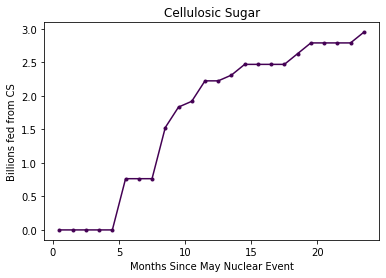

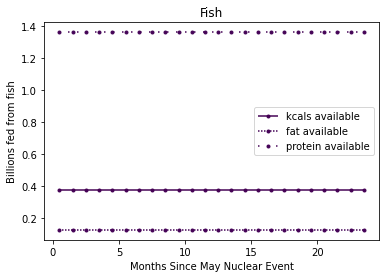

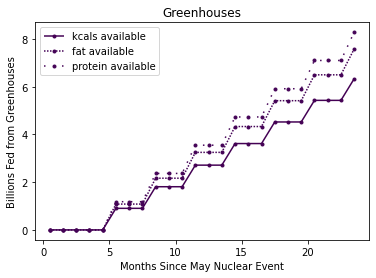

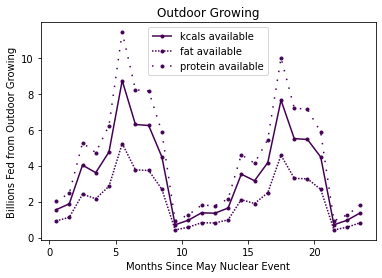

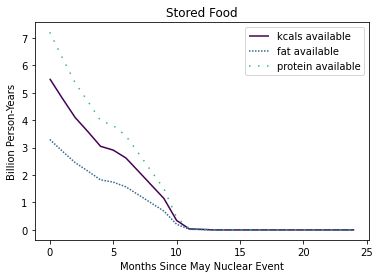

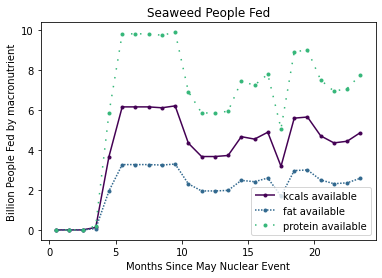

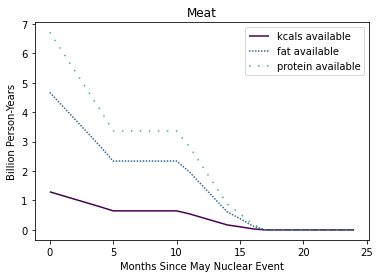

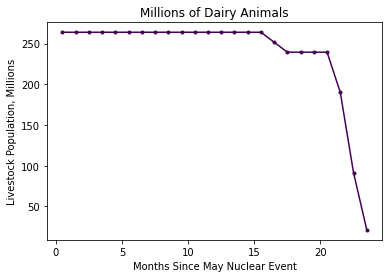

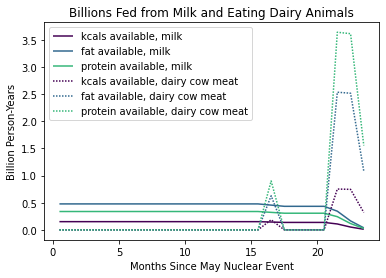

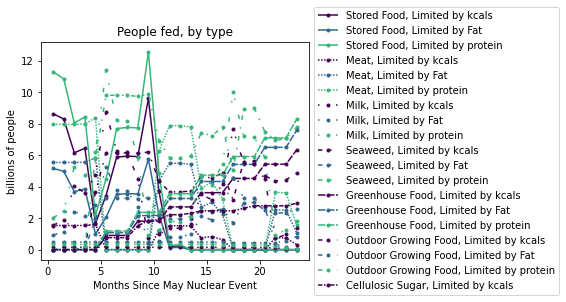

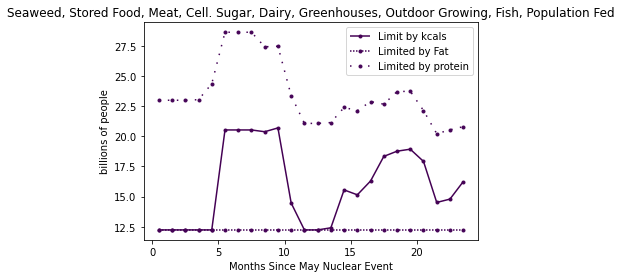

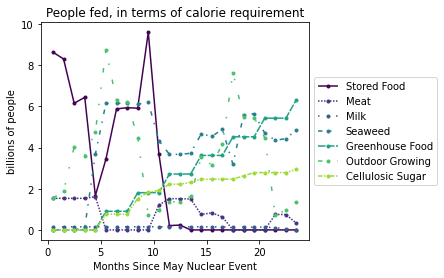

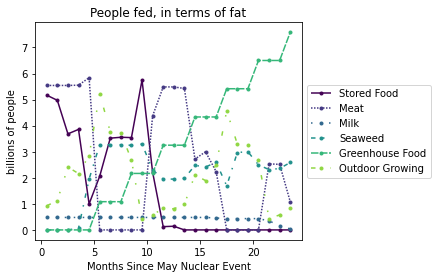

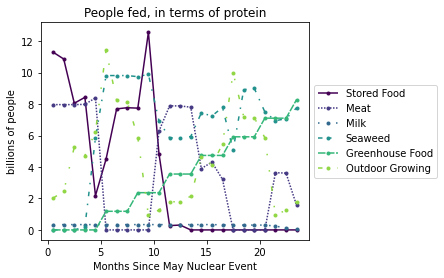

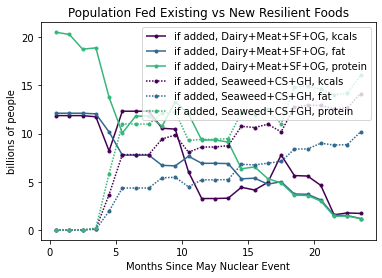

In [13]:

if(constants['inputs']['ADD_CELLULOSIC_SUGAR']):
    Plotter.plot_CS(time_months_middle,analysis)
    # pass

if(constants['inputs']['ADD_FISH']):
    Plotter.plot_fish(time_months_middle,analysis)
    # pass
if(constants['inputs']['ADD_GREENHOUSES']):
    Plotter.plot_GH(time_months_middle,analysis)
    # pass
if(constants['inputs']['ADD_OUTDOOR_GROWING']):
    Plotter.plot_OG(time_months_middle,analysis)
    # pass

if(constants['inputs']['ADD_STORED_FOOD']):
    Plotter.plot_stored_food(time_months,analysis)

if(constants['inputs']['ADD_SEAWEED']):
    Plotter.plot_seaweed(time_months_middle,analysis)

if(constants['inputs']['ADD_NONEGG_NONDAIRY_MEAT']):
    Plotter.plot_nonegg_nondairy_meat(time_months,analysis)
    # pass
if(constants['inputs']['ADD_DAIRY']):
    Plotter.plot_dairy_cows(time_months_middle,analysis)
    Plotter.plot_dairy(time_months_middle,analysis)
    # pass

Plotter.plot_people_fed(time_months_middle,analysis)
Plotter.plot_people_fed_combined(time_months_middle,analysis)
Plotter.plot_people_fed_kcals(time_months_middle,analysis)
Plotter.plot_people_fed_fat(time_months_middle,analysis)
Plotter.plot_people_fed_protein(time_months_middle,analysis)
Plotter.plot_people_fed_comparison(time_months_middle,analysis)